In [1]:
"""
@author: Pearl Saldanha
"""

import numpy as np
import matplotlib.pyplot as plt
import nxsdk.api.n2a as nx
from nxsdk.utils.plotutils import plotRaster
import wta1d as wta1d
import os
os.environ["KAPOHOBAY"] = "1"


def create_spikegen(net, indices, spiketimes, numPorts=None):
    """
    creates a spikegenerator from a list of indices with corresponding spiketimes
    :param net: the nx net in which the spikegen is created
    :param indices: the neuron indices that correspond to the spiketimes
    :param spiketimes: times at which the spikegen spikes
    :param numPorts: the numebr of spikegen neurons, if None, it is the max of indices
    :param time_step: time in milliseconds
    :return: spikegenerator (needed to connect to other groups)
    """
    if numPorts is None:
        numPorts = np.max(indices)
        
    print('length of stimulation is', np.max(spiketimes), 'timesteps')
    spikegen = net.createSpikeGenProcess(numPorts=numPorts)
    for sg_neuron in np.unique(np.asarray(indices)):
        spikegen.addSpikes(spikeInputPortNodeIds=sg_neuron,
                           spikeTimes=list(spiketimes[np.where(indices == sg_neuron)]))
    return spikegen

def plotStdpDynamics(timeDelta, weightDeltas):
    plt.figure(3, figsize=(9,5))
    
    plt.scatter(timeDelta, weightDeltas)
    plt.title('STDP weight change')
    plt.xlabel('t_post - t_pre')
    plt.ylabel('Weight change')
        
    plt.tight_layout()
    plt.show()


In [2]:
net = nx.NxNet()

training_learning = True # if false then it means you are in the recall phase which means that there is no spikes given to the spikegen resulting in synfire chain not firin

#ports
num_syn = 36
num_recall =  36 

# num_syn2 = 30
# num_recall2 = 30 


spiketimes = np.asarray([5,6,8,9,10,11,12,1000,1001,1002,1003,1004,1005,1006]) 
indices =np.asarray([0]*len(spiketimes))

# spiketimes1 = np.asarray([3000, 3001 , 3002, 3003, 3004 , 3005, 3006, 4000, 4001, 4002, 4003, 4004, 4005, 4006])
# indices1 =np.asarray([0]*len(spiketimes))

time_step = 1.00 #GLOBAL time step duration in milliseconds (spiking rate and time constant defined in MILLISECONDS)
simulated_time = 3000 #length of the simulation in milliseconds
sumulated_steps = int(simulated_time/time_step) #number of simulated steps
runtime = sumulated_steps

print("Length of 'indices' = ", len(indices))
print("Length of 'spiketime' = ", len(spiketimes))
print("Print-out of indices array: ", indices)

Length of 'indices' =  14
Length of 'spiketime' =  14
Print-out of indices array:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0]


[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


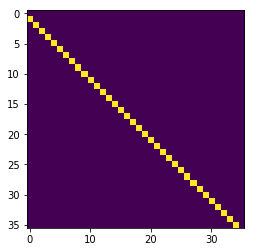

In [3]:
sf1 = nx.CompartmentPrototype(biasMant=0,
                            biasExp=0,
                            vThMant=20000,
                            functionalState=2,
                            refractoryDelay=2,
                            compartmentVoltageDecay=int(4096/20),
                            compartmentCurrentDecay=int(4096/15),
                            numDendriticAccumulators = 16,   
                            enableSpikeBackprop = 1,
                            enableSpikeBackpropFromSelf = 1,
                            logicalCoreId=0)

synfire1 = net.createCompartmentGroup(size=num_syn, prototype=sf1)

# sf2 = nx.CompartmentPrototype(biasMant=0,
#                             biasExp=0,
#                             vThMant=20000,
#                             functionalState=2,
#                             refractoryDelay=2,
#                             compartmentVoltageDecay=int(4096/20),
#                             compartmentCurrentDecay=int(4096/15),
#                             numDendriticAccumulators = 16,   
#                             logicalCoreId=0)

# synfire2 = net.createCompartmentGroup(size=num_syn2, prototype=sf2)

#connection prototype
conn_proto_exc = nx.ConnectionPrototype(signMode=nx.SYNAPSE_SIGN_MODE.EXCITATORY,
                                        weight=145,
                                        weightExponent=4,
                                        numWeightBits=6,
                                        enableDelay=1,
                                        numDelayBits =4,
                                        delay=14)

#connection mask                                     
conn_mask = np.zeros((num_syn,num_syn))
for i in range(num_syn-1):
    #conn_mask[i,i+1]= 1
    conn_mask[i+1,i] = 1
    
print(conn_mask)
plt.imshow(conn_mask)

#compartment connections
exc_exc = synfire1.connect(synfire1, prototype=conn_proto_exc,connectionMask=conn_mask)

# conn_mask2 = np.zeros((num_syn2,num_syn2))
# for i in range(num_syn-1):
#     #conn_mask[i,i+1]= 1
#     conn_mask[i+1,i] = 1
    
# print(conn_mask2)
# plt.imshow(conn_mask2)
# exc_exc2 = synfire2.connect(synfire2, prototype=conn_proto_exc,connectionMask=conn_mask2)

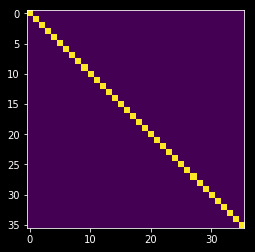

In [21]:
sr1 = nx.CompartmentPrototype(biasMant=0,
                            biasExp=0,
                            vThMant=22000,
                            functionalState=2,
                            refractoryDelay=2,
                            compartmentVoltageDecay=int(4096/20),
                            compartmentCurrentDecay=int(4096/15),
                            numDendriticAccumulators = 16,   
                            enableSpikeBackprop = 1,
                            enableSpikeBackpropFromSelf = 1,
                            logicalCoreId=0)

synrecall1 = net.createCompartmentGroup(size=num_recall, prototype=sr1)

conn_mask_recall = np.zeros((num_recall,num_syn))
for i in range(num_syn):
#     if i < num_recall:
        conn_mask_recall[i,i] = 1
plt.imshow(conn_mask_recall)       

#connection from synfire chain to the recall chain
syn_sr = synfire1.connect(synrecall1, prototype=conn_proto_exc,connectionMask=conn_mask_recall)

length of stimulation is 1006 timesteps


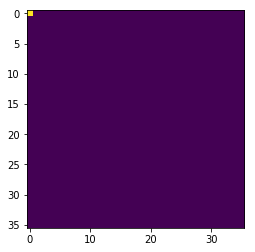

In [4]:
# =======================================================
# Creation of connections from spikeGen to synfire chain
# =======================================================

# Connection mask for the spikeGen
conn_mask_spikegen = np.zeros((num_syn, num_syn))
# conn_mask_spikegen[0,:] = 1  # Connects all spikeGen ports to only the first neuron in the synfire chain
conn_mask_spikegen[0,0] = 1  # Connects only the first port of the spikeGen to the first neuron in the synfire chain

# Draw excitatory connections from the spikeGen (using 'conn_mask_spikegen')
# sg = create_spikegen(net, indices, spiketimes, numPorts=num_src)

# spike_gen.connect(cx_grp,
#                   prototype=conn_proto,
#                   weight=np.ones((num_dst, num_src)) * int(weight_steps),
#                   delay=np.ones((num_dst, num_src)) * int(delay_steps),
#                   connectionMask=conn_mask)

# # Plot connection mask
# if plotConnMatrices or printConnMatrices:
#     print("Connection matrix for spike gen to synfire chain:")
# if plotConnMatrices:
plt.imshow(conn_mask_spikegen)
# if printConnMatrices:
#     print(conn_mask_spikegen)


# spike generator
sg = create_spikegen(net, indices, spiketimes, numPorts=num_syn)
sg.connect(synfire1,
           prototype=conn_proto_exc,
            connectionMask=conn_mask_spikegen)


# conn_mask_spikegen = np.zeros((num_syn2, num_syn2))
# # conn_mask_spikegen[0,:] = 1  # Connects all spikeGen ports to only the first neuron in the synfire chain
# conn_mask_spikegen[0,0] = 1

# # spike generator
# sg2 = create_spikegen(net, indices1, spiketimes1, numPorts=num_syn2)
# sg2.connect(synfire2,
#            prototype=conn_proto_exc,
#             connectionMask=conn_mask_spikegen)

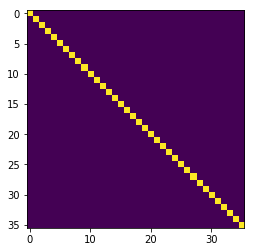

In [5]:
sr1 = nx.CompartmentPrototype(biasMant=0,
                            biasExp=0,
                            vThMant=20000,
                            functionalState=2,
                            refractoryDelay=2,
                            compartmentVoltageDecay=int(4096/20),
                            compartmentCurrentDecay=int(4096/15),
                            numDendriticAccumulators = 16,   
                            enableSpikeBackprop = 1,
                            enableSpikeBackpropFromSelf = 1,
                            logicalCoreId=0)

synrecall1 = net.createCompartmentGroup(size=num_recall, prototype=sr1)

conn_mask_recall = np.zeros((num_recall,num_syn))
for i in range(num_syn):
#     if i < num_recall:
        conn_mask_recall[i,i] = 1
plt.imshow(conn_mask_recall)       

#connection from synfire chain to the recall chain
syn_sr = synfire1.connect(synrecall1, prototype=conn_proto_exc,connectionMask=conn_mask_recall)

# #Second recall chain
# sr2 = nx.CompartmentPrototype(biasMant=0,
#                             biasExp=0,
#                             vThMant=20000,
#                             functionalState=2,
#                             refractoryDelay=2,
#                             compartmentVoltageDecay=int(4096/20),
#                             compartmentCurrentDecay=int(4096/15),
#                             numDendriticAccumulators = 16,   
#                             logicalCoreId=0)

# synrecall2 = net.createCompartmentGroup(size=num_recall, prototype=sr2)

# conn_mask_recall2 = np.zeros((num_recall2,num_syn2))
# for i in range(num_syn2):
# #     if i < num_recall:
#         conn_mask_recall2[i,i] = 1

# #connection from synfire chain to the recall chain
# syn_sr2 = synfire2.connect(synrecall2, prototype=conn_proto_exc,connectionMask=conn_mask_recall2)

In [6]:
# =======================================================
# WTA parameters
# =======================================================

wta_size = 6
sigma =1.4625#1.45#546#1.425
weight_max = 200 #150#120
weight_min_global = -0.4*weight_max #20
#weight_min_peak = -10.0*weight_max + shift#min weight in the negative peaks of the mexican hat function (DoG implementation)
syn_delay = 1
self_excitation = True
#input paramters
input_max_weight = 150#150

#---------------------------------------------------------------------------------------------------
#For the post synaptic traces to be
# updated we need to enable the back propagation of action potential whenever the compartment spikes.
# so we don't need that now
#---------------------------------------------------------------------------------------------------

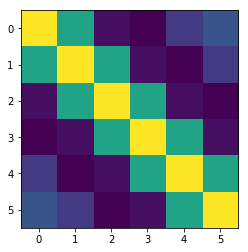

In [7]:
# =======================================================
# WTA compartment creation using the WTA1d module
# =======================================================


cx_proto = wta1d.create_compartment_prototype(time_step = time_step,
                                             tau_current_decay = 10,
                                             tau_voltage_decay = 150,#150,
                                             threshold_voltage_mant = 4100,# 3000, #*2^6
                                             min_voltage_exp = 16,#17,#-2^min_voltage_exp
                                             enable_backprop = True, #learning between wtas
                                             logicalCoreId=1)

#create wta
wta = wta1d.WtaNet(net,wta_size,'mexican',sigma,0,weight_min_global,
                     weight_max,self_excitation,syn_delay,time_step,cx_proto)

wta.create()
# wta.print_parameters()
# print(wta.w_matrix)
plt.imshow(wta.w_matrix)

In [8]:
#Spike PARAMETERS

std_dev_teaching = 1.0 #1.5#2.0 #std dev teaching signal
weight_max_teaching = 225#150*1.5
weight_min_teaching = 0
weight_exponent_teaching = 2
#testing
n_test_samples = wta_size-2#*3# wta_size-2
random_test_samples = False #random walk to test

test_sample_duration = 110 #1200/ number of steps of exposure time for each training sample
test_sample_pause = 0

In [9]:
# =======================================================
# WTA spike generator
# =======================================================

# Connection prototypes (not all used)
conn_proto_ex = nx.ConnectionPrototype(signMode=nx.SYNAPSE_SIGN_MODE.EXCITATORY)
connProtoInh = nx.ConnectionPrototype(signMode=nx.SYNAPSE_SIGN_MODE.INHIBITORY)
connProtoMix = nx.ConnectionPrototype(signMode=nx.SYNAPSE_SIGN_MODE.MIXED)

# Spike generator parameters
input_std_dev = 0  #1 #std dev in "neuron units", if set to 0, connections will become exaclty identity
input_max_weight = 240 #weight_max_teaching#240
input_min_weight = 0 #weight_min_teaching  #set to 0 for excitatory only connections
input_delay = 2

#TEACHING SPIKE GENERATOR
# input_weight_2_max = weight_max_teaching#150*1.5
# input_weight_2_min = weight_min_teaching#-240
# input_delay_2 = 2#2 delay should help, read GENERALIZATION subsection of rbf network chapter
#connection prototype width additional weight exponent
connProtoMixStrong = nx.ConnectionPrototype(signMode=nx.SYNAPSE_SIGN_MODE.MIXED,enableLearning=0,weightExponent=weight_exponent_teaching)
#conect to readout layer (here readout layer)
# teaching_spike_gen = wta1d.create_wta_spike_gen(readout_size,time_step,input_weight_2_min,input_weight_2_max,input_delay_2,std_dev_teaching
#                                         ,readout_compartments,connProtoMixStrong,net,'gaussian')
# Create spike generator
teaching_spike_gen = wta1d.create_wta_spike_gen(wta_size,time_step,input_min_weight,input_max_weight,input_delay,input_std_dev
                                        ,wta.compartments,connProtoMixStrong,net,'gaussian')

# teaching_spike_gen = wta1d.create_wta_spike_gen(wta_size,time_step,input_min_weight,input_max_weight,input_delay,input_std_dev
#                                         ,wta.compartments,connProtoMixStrong,net,'gaussian')

[[240.   0.   0.   0.   0.   0.]
 [  0. 240.   0.   0.   0.   0.]
 [  0.   0. 240.   0.   0.   0.]
 [  0.   0.   0. 240.   0.   0.]
 [  0.   0.   0.   0. 240.   0.]
 [  0.   0.   0.   0.   0. 240.]]


In [10]:
#Spike generation and probes
import math

#Firing rate
firing_rate = 100#50 #in hertz

#firing_period = 1000/firing_rate #milliseconds
#period_steps = int(firing_period/time_step) #period between spikes (in hardware steps)

backg_fr = 0#5 #background firing rate

r_trials = 12
input_std_dev = 0#0.5
min_firing_threshold = 1


#INPUTS
#generate spike list for all INPUT neurons
input_spikes = [np.array([0])]*wta_size 

#generate LIST of input vectors
input_vectors = []

#seed random gen
np.random.seed(1)
multiplier = 1

# for training 

wta1d.add_gaussian_input(5,firing_rate,backg_fr,runtime*0*multiplier,runtime*0.04*multiplier, wta_size,input_spikes,
                       time_step,r_trials,input_std_dev,min_firing_threshold)
wta1d.add_gaussian_input(4,firing_rate,backg_fr,runtime*0.03*multiplier,runtime*0.08*multiplier, wta_size,input_spikes,
                       time_step,r_trials,input_std_dev,min_firing_threshold)
wta1d.add_gaussian_input(3,firing_rate,backg_fr,runtime*0.07*multiplier,runtime*0.12*multiplier, wta_size,input_spikes,
                       time_step,r_trials,input_std_dev,min_firing_threshold)
wta1d.add_gaussian_input(2,firing_rate,backg_fr,runtime*0.11*multiplier,runtime*0.16*multiplier, wta_size,input_spikes,
                       time_step,r_trials,input_std_dev,min_firing_threshold)
wta1d.add_gaussian_input(1,firing_rate,backg_fr,runtime*0.15*multiplier,runtime*0.20*multiplier, wta_size,input_spikes,
                       time_step,r_trials,input_std_dev,min_firing_threshold)
wta1d.add_gaussian_input(0,firing_rate,backg_fr,runtime*0.19*multiplier,runtime*0.24*multiplier, wta_size,input_spikes,
                       time_step,r_trials,input_std_dev,min_firing_threshold)

#for recall
wta1d.add_gaussian_input(5,firing_rate,backg_fr,runtime*0.67*multiplier,runtime*0.71*multiplier, wta_size,input_spikes,
                       time_step,r_trials,input_std_dev,min_firing_threshold)
wta1d.add_gaussian_input(4,firing_rate,backg_fr,runtime*0.70*multiplier,runtime*0.76*multiplier, wta_size,input_spikes,
                       time_step,r_trials,input_std_dev,min_firing_threshold)
wta1d.add_gaussian_input(3,firing_rate,backg_fr,runtime*0.75*multiplier,runtime*0.81*multiplier, wta_size,input_spikes,
                       time_step,r_trials,input_std_dev,min_firing_threshold)
wta1d.add_gaussian_input(2,firing_rate,backg_fr,runtime*0.80*multiplier,runtime*0.86*multiplier, wta_size,input_spikes,
                       time_step,r_trials,input_std_dev,min_firing_threshold)
wta1d.add_gaussian_input(1,firing_rate,backg_fr,runtime*0.85*multiplier,runtime*0.90*multiplier, wta_size,input_spikes,
                       time_step,r_trials,input_std_dev,min_firing_threshold)
wta1d.add_gaussian_input(0,firing_rate,backg_fr,runtime*0.89*multiplier,runtime*0.96*multiplier, wta_size,input_spikes,
                       time_step,r_trials,input_std_dev,min_firing_threshold)

In [11]:
#Spike generation and probes
#authors for this function
"""
@authors: Davide Plozza, Damiano Steger
"""
import math

n_training_passes = 1 #how many cycles of training (during each cycle all training samples are exposed once, in the
                      # specified order)
generalization_factor = 1
training_sample_spacing = generalization_factor#2#3 #spacing between input sample "positions" in wta. It refers to the input samples if 
                    #use_inverse_for_training= False, else it refers to output injected samples
                    #it is the "generalization factor"
training_length = 900
steps_per_wave = wta_size
n_waves_per_training_length = 1
n_training_samples = steps_per_wave * n_waves_per_training_length #wta_size//training_sample_spacing#(wta_size-2)//sample_spacing + 1

training_sample_duration = (training_length // n_waves_per_training_length) // steps_per_wave

training_sample_pause = 0 #pause in steps between training samples

waiting_steps = 1000 #pause between training and testing
ending_steps = waiting_steps//2 #pause at the end

#testing
test_length = 1000
steps_per_wave = wta_size
n_waves_per_training_length = 1
n_test_samples = steps_per_wave * n_waves_per_training_length
random_test_samples = False #random walk to test

test_sample_duration = (training_length // n_waves_per_training_length) // steps_per_wave #1200/ number of steps of exposure time for each training sample
test_sample_pause = 0

def func_to_learn(x):
    aux_x = np.fmod(x,steps_per_wave)
    return 12+11*np.sin(np.pi*(aux_x/steps_per_wave))



def map1d(x):
    return  int((func_to_learn(x)+0.5)%wta_size)#-1)%(wta_size-2)+1

def map1d_inv(y):
    return  int((func_to_learn_inv(y)+0.5)%wta_size)

#INPUT and TEACHING SIGNAL parameters

#Firing rate
firing_rate_input = 200 #in hertz
firing_rate_teach = 200 #firing rate teaching signal

min_firing_threshold = 1

#input
r_trials_input = 12#12 #order of the gamma distribution of the renewal process
std_dev_input = 1
backg_fr_input = 0#5 #background firing rate

#teaching signal
r_trials_teach = 12#12 #order of the gamma distribution of the renewal process
std_dev_teach = 1 #delta fuction
backg_fr_teach = 0 #background firing rate

#generate LIST of input vectors for plotting
#if watn to plot a vector only in a specific region, add an element to this list composed from 
#a tuple of two elements: timesteps and values. Use function "wta1d.add_plot_vector_costant"
input_vectors = []
teaching_vectors = []

#seed random gen
np.random.seed(1)


#generate spike list for all INPUT neurons
input_spikes = [np.array([0])]*wta_size 


#seed random gen
np.random.seed(1)
training_cycle_steps = n_training_samples*training_sample_duration + (n_training_samples-1)*training_sample_pause
training_steps =training_cycle_steps*n_training_passes
sample_step = training_sample_spacing
training_start = 0
for x in range(n_training_samples):
            #if (x == 1): continue
            xin = x*sample_step+ 0.01
            wta1d.add_gaussian_input(map1d(xin),firing_rate_teach,backg_fr_teach,
                                     int((training_sample_duration+training_sample_pause)*x)+1,
                                     int((training_sample_duration+training_sample_pause)*x+training_sample_duration)+1,
                                    wta_size,input_spikes,time_step,r_trials_teach,std_dev_teach,min_firing_threshold,
                                    teaching_vectors)

#TESTS

#user defined test_steps = runtime-training_steps-waiting_steps#0.05*runtime
test_start = training_steps+waiting_steps#0.05*runtime
n_tests = n_test_samples#wta_size-2
margin_width = 1#width of "not usable" values at the margins of wta
test_steps = n_tests*test_sample_duration + (n_tests-1)*test_sample_pause
#test_duration = 1/n_tests #0.1 #duration of one learning sample, in %of total time
# for x in range(0,n_tests)
    if random_test_samples:
        xTest = np.random.randint(margin_width,wta_size-margin_width)
    else:
#         xTest = x+margin_width
        xTest = x*sample_step+ 0.01
    #tests_spikes = np.arange(int(test_start+(test_sample_duration+test_sample_pause)*x)+1,
    #                         int(test_start+(test_sample_duration+test_sample_pause)*x+test_sample_duration)+1,
    #                         period_steps_1)
    #input_spikes[xTest] =np.append(input_spikes[xTest],tests_spikes)
    wta1d.add_gaussian_input(map1d(xTest),firing_rate_teach,backg_fr_teach,
                             int(test_start+(test_sample_duration+test_sample_pause)*x)+1,
                             int(test_start+(test_sample_duration+test_sample_pause)*x+test_sample_duration)+1,
                            wta_size,input_spikes,time_step,r_trials_input,std_dev_input,min_firing_threshold,
                            teaching_vectors)

input_spike_times = wta1d.add_spikes_to_gen(wta_size,input_spikes,teaching_spike_gen)

wta.create_probes(voltage_and_current=False)
sh = plotRaster(input_spike_times)

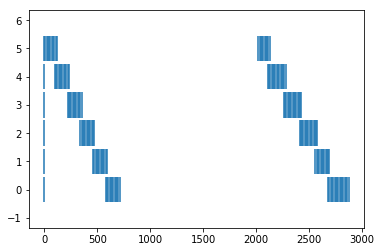

In [12]:
# #sequence 2 spikes 
# run1_mult = 0.8
# multiplier2 = 2

# wta1d.add_gaussian_input(0,firing_rate,backg_fr,runtime*0.50*run1_mult,runtime*0.52*run1_mult, wta_size,input_spikes,
#                        time_step,r_trials,input_std_dev,min_firing_threshold)
# wta1d.add_gaussian_input(1,firing_rate,backg_fr,runtime*0.51*run1_mult,runtime*0.53*run1_mult, wta_size,input_spikes,
#                        time_step,r_trials,input_std_dev,min_firing_threshold)
# wta1d.add_gaussian_input(2,firing_rate,backg_fr,runtime*0.52*run1_mult,runtime*0.55*run1_mult, wta_size,input_spikes,
#                        time_step,r_trials,input_std_dev,min_firing_threshold)
# wta1d.add_gaussian_input(3,firing_rate,backg_fr,runtime*0.54*run1_mult,runtime*0.57*run1_mult, wta_size,input_spikes,
#                        time_step,r_trials,input_std_dev,min_firing_threshold)
# wta1d.add_gaussian_input(4,firing_rate,backg_fr,runtime*0.56*run1_mult,runtime*0.59*run1_mult, wta_size,input_spikes,
#                        time_step,r_trials,input_std_dev,min_firing_threshold)
# wta1d.add_gaussian_input(5,firing_rate,backg_fr,runtime*0.58*run1_mult,runtime*0.61*run1_mult, wta_size,input_spikes,
#                        time_step,r_trials,input_std_dev,min_firing_threshold)

# wta1d.add_gaussian_input(0,firing_rate,backg_fr,runtime*0.68*run1_mult,runtime*0.70*run1_mult, wta_size,input_spikes,
#                        time_step,r_trials,input_std_dev,min_firing_threshold)
# wta1d.add_gaussian_input(1,firing_rate,backg_fr,runtime*0.66*run1_mult,runtime*0.69*run1_mult, wta_size,input_spikes,
#                        time_step,r_trials,input_std_dev,min_firing_threshold)
# wta1d.add_gaussian_input(2,firing_rate,backg_fr,runtime*0.64*run1_mult,runtime*0.67*run1_mult, wta_size,input_spikes,
#                        time_step,r_trials,input_std_dev,min_firing_threshold)
# wta1d.add_gaussian_input(3,firing_rate,backg_fr,runtime*0.62*run1_mult,runtime*0.65*run1_mult, wta_size,input_spikes,
#                        time_step,r_trials,input_std_dev,min_firing_threshold)
# wta1d.add_gaussian_input(4,firing_rate,backg_fr,runtime*0.60*run1_mult,runtime*0.63*run1_mult, wta_size,input_spikes,
#                        time_step,r_trials,input_std_dev,min_firing_threshold)
# #================================================================================================================================================
# wta1d.add_gaussian_input(0,firing_rate,backg_fr,runtime*0.50*multiplier2*run1_mult,runtime*0.52*multiplier2*run1_mult, wta_size,input_spikes,
#                        time_step,r_trials,input_std_dev,min_firing_threshold)
# wta1d.add_gaussian_input(1,firing_rate,backg_fr,runtime*0.51*multiplier2*run1_mult,runtime*0.53*multiplier2*run1_mult, wta_size,input_spikes,
#                        time_step,r_trials,input_std_dev,min_firing_threshold)
# wta1d.add_gaussian_input(2,firing_rate,backg_fr,runtime*0.52*multiplier2*run1_mult,runtime*0.55*multiplier2*run1_mult, wta_size,input_spikes,
#                        time_step,r_trials,input_std_dev,min_firing_threshold)
# wta1d.add_gaussian_input(3,firing_rate,backg_fr,runtime*0.54*multiplier2*run1_mult,runtime*0.57*multiplier2*run1_mult, wta_size,input_spikes,
#                        time_step,r_trials,input_std_dev,min_firing_threshold)
# wta1d.add_gaussian_input(4,firing_rate,backg_fr,runtime*0.56*multiplier2*run1_mult,runtime*0.59*multiplier2*run1_mult, wta_size,input_spikes,
#                        time_step,r_trials,input_std_dev,min_firing_threshold)
# wta1d.add_gaussian_input(5,firing_rate,backg_fr,runtime*0.58*multiplier2*run1_mult,runtime*0.61*multiplier2*run1_mult, wta_size,input_spikes,
#                        time_step,r_trials,input_std_dev,min_firing_threshold)

# wta1d.add_gaussian_input(0,firing_rate,backg_fr,runtime*0.68*multiplier2*run1_mult,runtime*0.70*multiplier2*run1_mult, wta_size,input_spikes,
#                        time_step,r_trials,input_std_dev,min_firing_threshold)
# wta1d.add_gaussian_input(1,firing_rate,backg_fr,runtime*0.66*multiplier2*run1_mult,runtime*0.69*multiplier2*run1_mult, wta_size,input_spikes,
#                        time_step,r_trials,input_std_dev,min_firing_threshold)
# wta1d.add_gaussian_input(2,firing_rate,backg_fr,runtime*0.62*multiplier2*run1_mult,runtime*0.67*multiplier2*run1_mult, wta_size,input_spikes,
#                        time_step,r_trials,input_std_dev,min_firing_threshold)
# wta1d.add_gaussian_input(3,firing_rate,backg_fr,runtime*0.62*multiplier2*run1_mult,runtime*0.63*multiplier2*run1_mult, wta_size,input_spikes,
#                        time_step,r_trials,input_std_dev,min_firing_threshold)
# wta1d.add_gaussian_input(4,firing_rate,backg_fr,runtime*0.60*multiplier2*run1_mult,runtime*0.62*multiplier2*run1_mult, wta_size,input_spikes,
#                        time_step,r_trials,input_std_dev,min_firing_threshold)


input_spike_times = wta1d.add_spikes_to_gen(wta_size,input_spikes,teaching_spike_gen)
uh = plotRaster(input_spike_times)

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


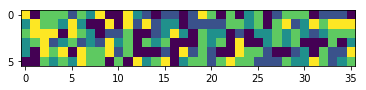

In [13]:
# =====================================================================
# Establishing learning rule between the synfire chain the WTA network
# =====================================================================


# x1Imp = 64#9#64# 20
# x1Tau = 10#90#10#50#25

# x2Imp = 10
# x2Tau = 90

# y1Imp = 10#64#40
# y1Tau = 90#10#25

# tEpoch = 4

x1Imp = 22#24#12#8#6#10 #32 #64#9#64# 20
x1Tau = 50#100#200#180 #25 #10#90#10#50#25  

# x2Imp = 10
# x2Tau = 90

y1Imp = 12#8
y1Tau = 4#5

tEpoch = 4


#use only x0 and y0 times a constant: dw = C*xo
#avg-dw-increase-per-time step will be C*avg-spiks-per-time-step = C*firing-rate

# Create an E-STDP learning rule used by the learning-enabled synapse and connect the pre synaptic spike generator.

lr = net.createLearningRule(#dw ='2^-6*(x1-4)*(128-w)*y0-2^-2*x0*', 
dt='u0*y1-u0*t', 
dw = '2^-2*x1*y0 - 2^-2*y1*x0',
                            x1Impulse=x1Imp,
                            x1TimeConstant=x1Tau,
                            #x2Impulse=x2Imp,
                            #x2TimeConstant=x2Tau,
                            y1Impulse=y1Imp,
                            y1TimeConstant=y1Tau,
                            tEpoch=tEpoch)

#connection protoype with learning rule, excitatory only weights
conn_proto_lrn = nx.ConnectionPrototype(#weight=50,
                                        enableLearning=1,
                                        learningRule=lr,
                                        numTagBits=8,
                                        #weightLimitMant = 12,#144
                                        #weigthLimitExp = 2,
                                        signMode=nx.SYNAPSE_SIGN_MODE.EXCITATORY)


# =======================================================
# Weight parameters for the learning rule
# =======================================================


max_plastic_weight = 5
random_plastic_weights = True
#initialize random or nonrandom connnections
max_weight = max_plastic_weight#10

if (random_plastic_weights):
    np.random.seed(0)
    w_matrix=np.random.randint(0, max_weight, size=(wta_size,num_syn))
else:
    w_matrix=np.ones((wta_size,num_syn))*max_weight
    for i in range(wta_size-1):
    #conn_mask[i,i+1]= 1
     w_matrix[i,i]= 1

# d_matrix2=np.zeros((num_src,wta_size))
m_matrix=np.ones((wta_size,num_syn)) #np.ones(wta_size) #mask (all ones for now)

plt.imshow(w_matrix)
#print(w_matrix2)#,m_matrix2,d_matrix2)
# print(m_matrix2)

# =======================================================
# Connect the synfire chain to the WTA compartments
# =======================================================


plastic_connections = synfire1.connect(wta.compartments, 
                                     prototype=conn_proto_lrn,
                                     weight=w_matrix,
#                                      delay=d_matrix2,
                                     connectionMask=m_matrix)

print(m_matrix)
# =======================================================
# Create weight probes to monitor the weight evolution
# =======================================================


#create synapse probes
connection_probes = {}
   #probes['wProbeNonLrn'] = connNonLrn.probe(nx.ProbeParameter.SYNAPSE_WEIGHT)

#set probeCOndition, for performance do NOT probe synapses too often (40x perdformance improvement)
weight_probe_start = 1
weight_probe_interval = 4
weight_probe_condition = nx.IntervalProbeCondition(dt=weight_probe_interval, tStart=weight_probe_start)
probe_list = plastic_connections.probe([nx.ProbeParameter.SYNAPSE_WEIGHT])
#                                          nx.ProbeParameter.PRE_TRACE_X1,
#                                          nx.ProbeParameter.SYNAPSE_TAG]) #[:][0]

connection_probes['wProbe'] = [item[0] for item in probe_list]
# connection_probes['x1Probe'] = [item[1] for item in probe_list]
# connection_probes['y1Probe'] = [item[2] for item in probe_list]

[[1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]]
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 

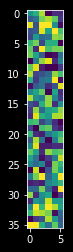

In [20]:
# Create an E-STDP learning rule used by the learning-enabled synapse and connect the pre synaptic spike generator.

x1Imp2 = 22#24#12#8#6#10 #32 #64#9#64# 20
x1Tau2 = 50#100#200#180 #25 #10#90#10#50#25  

# x2Imp = 10
# x2Tau = 90

y1Imp2 = 12#8
y1Tau2 = 4#5

tEpoch2 = 4

lr2 = net.createLearningRule(#dw ='2^-6*(x1-4)*(128-w)*y0-2^-2*x0*', 
dt='u0*y1-u0*t', 
dw = '2^-2*x1*y0 - 2^-2*y1*x0',
# dw = '2^-5*x1*(y1-12)*y0 - 2^-5*w*(y1-12)*y0',
#    dw='2^-5*x1*(y1-12)*y0', 
                            #dw = '2^-7*x1*y1*u1 - 2^-5*x1*u1',#dw = '2^3*x0*y0 - 2^-2*x0',#dw = '2^1*x0*y0 - 2^-5*x0 + 0*x1*x2*u0',#dw='-2^-2*x1*y0*sgn(w-50) - 2^-2*y1*x0',#dw='-2^-5*x1*y0*sgn(w-100) - 2^-5*x2*x0', #dw='-2^-4*w*u0', #dw='2^-2*x1*y0 - 2^-2*y1*x0',dw='2^-4*x1*y0 - 2^-7*x1*x0'
                            x1Impulse=x1Imp2,
                            x1TimeConstant=x1Tau2,
                            #x2Impulse=x2Imp,
                            #x2TimeConstant=x2Tau,
                            y1Impulse=y1Imp2,
                            y1TimeConstant=y1Tau2,
                            tEpoch=tEpoch2)

#connection protoype with learning rule, excitatory only weights
conn_proto_lrn2 = nx.ConnectionPrototype(#weight=50,
                                        enableLearning=1,
                                        learningRule=lr2,
                                        numTagBits=8,
                                        weightExponent = 4,
                                        #weightLimitMant = 12,#144
#                                         weigthLimitExp = 4,
                                        signMode=nx.SYNAPSE_SIGN_MODE.EXCITATORY)


# =======================================================
# Weight parameters for the learning rule
# =======================================================


max_plastic_weight2 = 25
random_plastic_weights1 = True
#initialize random or nonrandom connnections
max_weight2 = max_plastic_weight2#10

if (random_plastic_weights1):
    np.random.seed(0)
    w_matrix2=np.random.randint(0, max_weight2, size=(num_syn,wta_size))
else:
    w_matrix2=np.ones((num_syn,wta_size))*max_weight2
    for i in range(wta_size-1):
    #conn_mask[i,i+1]= 1
     w_matrix2[i,i]= 1

# d_matrix2=np.zeros((num_src,wta_size))
m_matrix2=np.ones((num_syn,wta_size)) #np.ones(wta_size) #mask (all ones for now)

plt.imshow(w_matrix2)

#print(w_matrix2)#,m_matrix2,d_matrix2)
print(m_matrix2)

# =======================================================
# Connect the synfire chain to the WTA compartments
# =======================================================


plastic_connections2 = wta.compartments.connect(synrecall1, 
                                     prototype=conn_proto_lrn2,
                                     weight=w_matrix2,
#                                      delay=d_matrix2,
                                     connectionMask=m_matrix2)
print(m_matrix)
# print(m_matrix2)
# =======================================================
# Create weight probes to monitor the weight evolution
# =======================================================


#create synapse probes
connection_probes2 = {}
   #probes['wProbeNonLrn'] = connNonLrn.probe(nx.ProbeParameter.SYNAPSE_WEIGHT)

#set probeCOndition, for performance do NOT probe synapses too often (40x perdformance improvement)
weight_probe_start2 = 1
weight_probe_interval2 = 4
weight_probe_condition2 = nx.IntervalProbeCondition(dt=weight_probe_interval2, tStart=weight_probe_start2)
probe_list_2 = plastic_connections2.probe([nx.ProbeParameter.SYNAPSE_WEIGHT,
                                         nx.ProbeParameter.PRE_TRACE_X1,
                                         nx.ProbeParameter.SYNAPSE_TAG]) #[:][0]

connection_probes2['wProbe2'] = [item[0] for item in probe_list_2]
connection_probes2['x1Probe2'] = [item[1] for item in probe_list_2]
connection_probes2['y1Probe2'] = [item[2] for item in probe_list_2]
#spike probe for recall chain



In [15]:
#Add probes
(u_probes, v_probes, s_probes) = synfire1.probe([nx.ProbeParameter.COMPARTMENT_CURRENT,
                                               nx.ProbeParameter.COMPARTMENT_VOLTAGE,
                                               nx.ProbeParameter.SPIKE])

(u2_probes, v2_probes, s2_probes) = synrecall1.probe([nx.ProbeParameter.COMPARTMENT_CURRENT,
                                               nx.ProbeParameter.COMPARTMENT_VOLTAGE,
                                               nx.ProbeParameter.SPIKE])


# Create probes for WTA network
probes = wta.create_probes(voltage_and_current=False) 

# (ur_probes, vr_probes, sr_probes) = synrecall1.probe([nx.ProbeParameter.COMPARTMENT_CURRENT,
#                                                nx.ProbeParameter.COMPARTMENT_VOLTAGE,
#                                                nx.ProbeParameter.SPIKE])
# (ur2_probes, vr2_probes, sr2_probes) = synrecall2.probe([nx.ProbeParameter.COMPARTMENT_CURRENT,
#                                                nx.ProbeParameter.COMPARTMENT_VOLTAGE,
#                                                nx.ProbeParameter.SPIKE])


In [16]:
net.run(runtime)
net.disconnect()

INFO:DRV:  Connecting to 127.0.0.1:18861
INFO:DRV:  N2Driver: Running...
INFO:DRV:      Compiling synapses... Done (0.02s)
INFO:DRV:      Processing probes... Done (0.02s)
INFO:DRV:      Writing modified registers... Done (0.02s)
INFO:DRV:      Initializing... Done (0.03s)
INFO:DRV:      Preparing input... Done (0.01s)
INFO:DRV:      Executing... Done (126.03s)
INFO:DRV:      Processing timeSeries... Done (13.95s)
INFO:DRV:  N2Driver: Finished (140.09s)


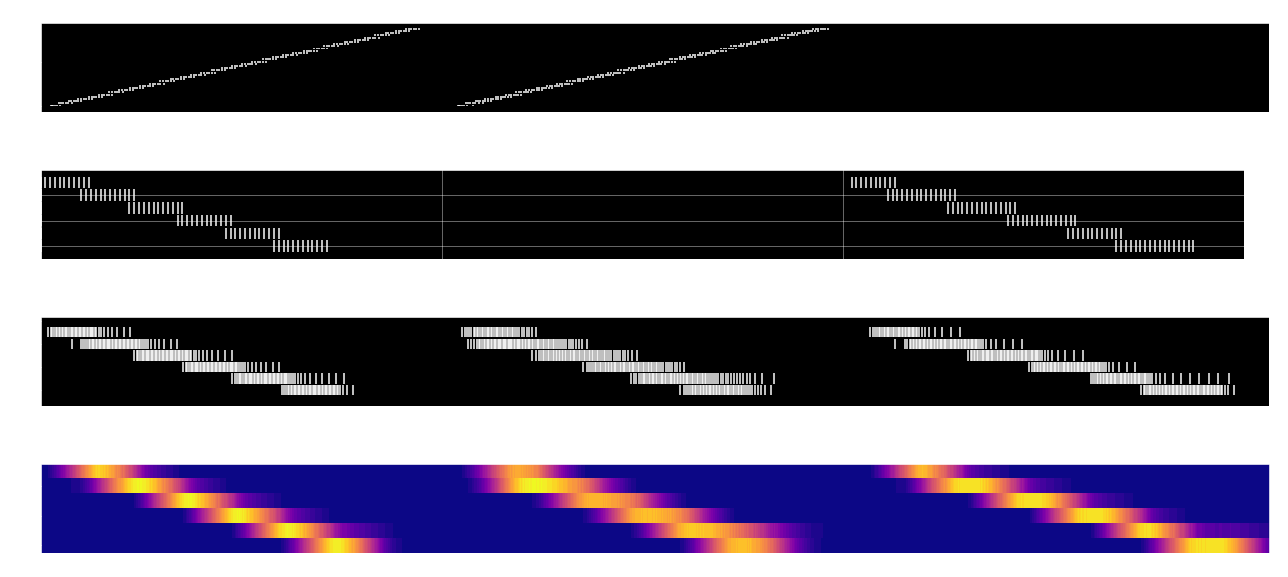

In [17]:
# =============
# Plot results
# =============

fig = plt.figure(1, figsize=(18,24))

plot_begin = 0
plot_end = runtime

n_plots = 12
i_plot = 1
time_tick_step = 1000
index_tick_step = 2
plt.style.use("dark_background") 

#colorbar size
cbar_fraction=0.01
cbar_pad=0.01
cmap = 'plasma'
#create fake image for fake colorbars
cbar_img = plt.imshow(np.zeros((1,1)))
# Plot synapse weights

# plt.subplot(n_plots,1,i_plot)
# wta1d.setup_spike_plot('Plastic connections weights',wta_size,plot_begin,plot_end,index_tick_step,False,
#                  time_tick_step,cbar_img,cbar_fraction,cbar_pad)
# for x in range(wta_size*wta_size):
#     connection_probes['wProbe'][x].plot()
# ====================================================================================================================

# Plot output spikes of the synfire chain
i_plot += 1
plt.subplot(n_plots,1,i_plot)
syn = s_probes.plot() #colors=[h.get_color() for h in uh])
plt.xlim(plot_begin,plot_end)
plt.xlabel("Time Steps")
plt.title('Spikes from synfire chain')
# ====================================================================================================================
# i_plot += 1
# plt.subplot(n_plots,1,i_plot)
# syn = s2_probes.plot() #colors=[h.get_color() for h in uh])
# plt.xlim(plot_begin,plot_end)
# plt.title('Spikes from synfire chain')
# ====================================================================================================================
# i_plot += 1
# plt.subplot(n_plots,1,i_plot)
# sr1 = sr_probes.plot() #colors=[h.get_color() for h in uh])
# plt.xlim(plot_begin,plot_end)
# plt.title('Spikes from recall chain')
# ====================================================================================================================
# i_plot += 1
# plt.subplot(n_plots,1,i_plot)
# sr1 = sr2_probes.plot() #colors=[h.get_color() for h in uh])
# plt.xlim(plot_begin,plot_end)
# plt.title('Spikes from recall chain')
# ====================================================================================================================
# Plot IPNUT spikes of WTA network
i_plot += 1
plt.subplot(n_plots,1,i_plot)
#ean_plot = wta1d.plot_input_vectors(teaching_vectors,'C1',0.25,5,"mean of the peaks")
sh = plotRaster(input_spike_times)
wta1d.setup_spike_plot("Teaching spike generator spikes",wta_size,plot_begin,plot_end,index_tick_step,True,
                       time_tick_step,cbar_img,cbar_fraction,cbar_pad)

# ====================================================================================================================
         
# Plot WTA spikes
i_plot += 1
plt.subplot(n_plots,1,i_plot)
probes['sProbeWTA'].plot()
plt.xlim(plot_begin,plot_end)
#plt.ylim(0,36)
plt.title('Output WTA spikes')

# ====================================================================================================================
         
#plot colormap firing rates
inst_firing_rate = wta1d.make_firing_rate_matrix(wta_size,plot_end,probes['sProbeWTA'],120)

i_plot += 1
ax = plt.subplot(n_plots,1,i_plot)
im = ax.imshow(inst_firing_rate,cmap = 'plasma', aspect='auto',zorder=-1,
                      origin='lower') #aspect='auto'
ax.set_title("WTA spike rates")


plt.tight_layout()
plt.show()

fig.savefig('synfire-wta_interaction.png',bbox_inches='tight', dpi=fig.dpi*2)

In [18]:
print("Spike counts:")
totalCount = 0
time = 900
for neuron in range(num_syn):
    spike_count = np.sum(s_probes[neuron].data)
    totalCount += spike_count
    print("    Neuron", str(neuron), ":", spike_count)
    
print("Total spike count:", totalCount, "\n")

# print("Spike times for spike generator:")
# print(spiketimes)

output_firingrate = totalCount/time
print("Average firing rate:")
print(output_firingrate)

output = np.where(s_probes[3].data)
print(output)

Spike counts:
    Neuron 0 : 13
    Neuron 1 : 13
    Neuron 2 : 13
    Neuron 3 : 13
    Neuron 4 : 13
    Neuron 5 : 13
    Neuron 6 : 13
    Neuron 7 : 13
    Neuron 8 : 13
    Neuron 9 : 13
    Neuron 10 : 13
    Neuron 11 : 13
    Neuron 12 : 13
    Neuron 13 : 13
    Neuron 14 : 13
    Neuron 15 : 13
    Neuron 16 : 13
    Neuron 17 : 13
    Neuron 18 : 13
    Neuron 19 : 13
    Neuron 20 : 13
    Neuron 21 : 13
    Neuron 22 : 13
    Neuron 23 : 13
    Neuron 24 : 13
    Neuron 25 : 13
    Neuron 26 : 13
    Neuron 27 : 13
    Neuron 28 : 13
    Neuron 29 : 13
    Neuron 30 : 13
    Neuron 31 : 13
    Neuron 32 : 13
    Neuron 33 : 13
    Neuron 34 : 13
    Neuron 35 : 13
Total spike count: 468 

Average firing rate:
0.52
(array([  91,   98,  104,  110,  116,  124, 1085, 1092, 1098, 1104, 1110,
       1116, 1123]),)


In [19]:
ur =ur_probes.plot()

NameError: name 'ur_probes' is not defined

In [ ]:
vr =vr_probes.plot()

In [ ]:
print("Spike counts:")
totalCount = 0
time = 750
for neuron in range(wta_size):
    spike_count = np.sum(probes['sProbeWTA'][neuron].data)
    totalCount += spike_count
    print("    Neuron", str(neuron), ":", spike_count)
    
print("Total spike count:", totalCount, "\n")

# print("Spike times for spike generator:")
# print(input_spike_times)

output_firingrate = totalCount/time
print("Average firing rate:")
print(output_firingrate)

output = np.where(probes['sProbeWTA'][3].data)
print(output)

In [ ]:
probedata = []
for probe in connection_probes['wProbe']:
    probedata.append(probe.data)
    
    
np.array(probedata).shape

plt.plot(np.array(probedata)[:,-1])

plt.figure()
plt.imshow(np.reshape(np.array(probedata)[:,-1],(wta_size,num_syn)))

In [ ]:
probedata = []
for probe in connection_probes2['x1Probe2']:
    probedata.append(probe.data)
    
    
np.array(probedata).shape

plt.plot(np.array(probedata)[:,-1])

plt.figure()
plt.imshow(np.reshape(np.sum(probedata,1),(num_syn,wta_size)))


# np.array(connection_probes['x1Probe'].data).shape


In [ ]:
probedata = []
for probe in connection_probes2['y1Probe2']:
    probedata.append(probe.data)
    
    
np.array(probedata).shape

plt.plot(np.array(probedata)[:,-1])

plt.figure()
plt.imshow(np.reshape(np.sum(probedata,1),(num_syn,wta_size)))


# np.array(connection_probes['x1Probe'].data).shape



In [ ]:
#plot TRACES
fig = plt.figure(1, figsize=(18,24))

x1_plot_begin = 0
x1_plot_end = runtime//weight_probe_interval

# Plot X1 TRACE (all culums values are the same since the trace is from the same pre synaptic neuron)
# use only the value on the first row
x1_tick_step = time_tick_step//weight_probe_interval
x_range = np.arange(0,num_syn,dtype=np.int) 
for i,x in enumerate(x_range):
# for x in range(num_syn):
#     plt.subplot((x_range),1,x+1)
    plt.subplot(len(x_range),1,i+1)
    plt.plot(connection_probes['x1Probe'][x].data,label = 'x1 trace') #plot()
#     plt.xlim(x1_plot_begin,x1_plot_end)
    plt.xticks(np.arange(x1_plot_begin,x1_plot_end,x1_tick_step),labels = [])
    plt.xlabel('')
    #plt.ylabel('Trace value')
    #plt.xlim(plot_begin,plot_end)
    title  = "WTA neuron index: " + str(x)
    plt.title(title,loc='left')
    plt.grid(True,alpha=0.4)
    
plt.xticks(np.arange(x1_plot_begin,x1_plot_end,x1_tick_step),
           labels = np.arange(x1_plot_begin,x1_plot_end,x1_tick_step)*weight_probe_interval)
plt.xlabel('Time')
    
# Plot y1 TRACE (all row values are the same since the trace is from the same pre synaptic neuron)
# use only the value on the first culum
#GOOD NEWS: loihi doesn't support the plotting of y1 trace yet :(
'''
for x in range(wta_size):
    plt.subplot(wta_size*2+1,1,wta_size + 1 + x + 1)
    plt.plot(connection_probes['x1Probe'][x].data) #plot()
    plt.xlim(plot_begin,plot_end)
    plt.title(x)
'''         
        
#plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
plt.show()

In [ ]:
#plot TRACES
fig = plt.figure(1, figsize=(18,24))

x1_plot_begin = 0
x1_plot_end = runtime//weight_probe_interval

# Plot X1 TRACE (all culums values are the same since the trace is from the same pre synaptic neuron)
# use only the value on the first row
x1_tick_step = time_tick_step//weight_probe_interval
x_range = np.arange(0,216,num_syn,dtype=np.int)
for i,x in enumerate(x_range):
# for x in range(num_syn+):
#     plt.subplot((x_range),1,x+1)
    plt.subplot(len(x_range),1,i+1)
    plt.plot(connection_probes['y1Probe'][x].data,label = 'y1 trace') #plot()
    plt.xlim(x1_plot_begin,x1_plot_end)
    plt.xticks(np.arange(x1_plot_begin,x1_plot_end,x1_tick_step),labels = [])
    plt.xlabel('')
    #plt.ylabel('Trace value')
    #plt.xlim(plot_begin,plot_end)
    title  = "WTA neuron index: " + str(x)
    plt.title(title,loc='left')
    plt.grid(True,alpha=0.4)
    
plt.xticks(np.arange(x1_plot_begin,x1_plot_end,x1_tick_step),
           labels = np.arange(x1_plot_begin,x1_plot_end,x1_tick_step)*weight_probe_interval)
plt.xlabel('Time')
    
# Plot y1 TRACE (all row values are the same since the trace is from the same pre synaptic neuron)
# use only the value on the first culum
#GOOD NEWS: loihi doesn't support the plotting of y1 trace yet :(
'''
for x in range(wta_size):
    plt.subplot(wta_size*2+1,1,wta_size + 1 + x + 1)
    plt.plot(connection_probes['y1Probe'][x].data) #plot()
    plt.xlim(plot_begin,plot_end)
    plt.title(x)
'''
        
#plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
plt.show()

In [ ]:
#plot TRACES
fig = plt.figure(1, figsize=(18,24))

x1_plot_begin = 0
x1_plot_end = runtime//weight_probe_interval

# Plot X1 TRACE (all culums values are the same since the trace is from the same pre synaptic neuron)
# use only the value on the first row
x1_tick_step = time_tick_step//weight_probe_interval
x_range = np.arange(0,num_syn,wta_size-1,dtype=np.int)
for i,x in enumerate(x_range):
# for x in range(num_syn):
#     plt.subplot((x_range),1,x+1)
    plt.subplot(len(x_range),1,i+1)
    plt.plot(connection_probes2['x1Probe2'][x].data,label = 'x1 trace2') #plot()
    plt.xlim(x1_plot_begin,x1_plot_end)
    plt.xticks(np.arange(x1_plot_begin,x1_plot_end,x1_tick_step),labels = [])
    plt.xlabel('')
    #plt.ylabel('Trace value')
    #plt.xlim(plot_begin,plot_end)
    title  = "WTA neuron index: " + str(x)
    plt.title(title,loc='left')
    plt.grid(True,alpha=0.4)
    
plt.xticks(np.arange(x1_plot_begin,x1_plot_end,x1_tick_step),
           labels = np.arange(x1_plot_begin,x1_plot_end,x1_tick_step)*weight_probe_interval)
plt.xlabel('Time')
    
# Plot y1 TRACE (all row values are the same since the trace is from the same pre synaptic neuron)
# use only the value on the first culum
#GOOD NEWS: loihi doesn't support the plotting of y1 trace yet :(
'''
for x in range(wta_size):
    plt.subplot(wta_size*2+1,1,wta_size + 1 + x + 1)
    plt.plot(connection_probes['x1Probe'][x].data) #plot()
    plt.xlim(plot_begin,plot_end)
    plt.title(x)
'''
        
#plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
plt.show()

In [ ]:
#plot TRACES
fig = plt.figure(1, figsize=(18,24))

x1_plot_begin = 0
x1_plot_end = runtime//weight_probe_interval

# Plot X1 TRACE (all culums values are the same since the trace is from the same pre synaptic neuron)
# use only the value on the first row
x1_tick_step = time_tick_step//weight_probe_interval
x_range = np.arange(0,num_syn,dtype=np.int)
for i,x in enumerate(x_range):
# for x in range(num_syn):
#     plt.subplot((x_range),1,x+1)
    plt.subplot(len(x_range),1,i+1)
    plt.plot(connection_probes2['y1Probe2'][x].data,label = 'y1 trace2') #plot()
    plt.xlim(x1_plot_begin,x1_plot_end)
    plt.xticks(np.arange(x1_plot_begin,x1_plot_end,x1_tick_step),labels = [])
    plt.xlabel('')
    #plt.ylabel('Trace value')
    #plt.xlim(plot_begin,plot_end)
    title  = "WTA neuron index: " + str(x)
    plt.title(title,loc='left')
    plt.grid(True,alpha=0.4)
    
plt.xticks(np.arange(x1_plot_begin,x1_plot_end,x1_tick_step),
           labels = np.arange(x1_plot_begin,x1_plot_end,x1_tick_step)*weight_probe_interval)
plt.xlabel('Time')
    
# Plot y1 TRACE (all row values are the same since the trace is from the same pre synaptic neuron)
# use only the value on the first culum
#GOOD NEWS: loihi doesn't support the plotting of y1 trace yet :(
'''
for x in range(wta_size):
    plt.subplot(wta_size*2+1,1,wta_size + 1 + x + 1)
    plt.plot(connection_probes['x1Probe'][x].data) #plot()
    plt.xlim(plot_begin,plot_end)
    plt.title(x)
'''
        
#plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
plt.show()

In [ ]:
# fig = plt.figure(1, figsize=(18,24))
# x1_plot_begin = 0
# x1_plot_end = runtime//weight_probe_interval
# x1_tick_step = time_tick_step//weight_probe_interval
# w_range = np.arange(0,432,num_syn,dtype=np.int)
# for i,x in enumerate(w_range):
#     plt.subplot(len(w_range),1,i+1)
#     plt.plot(connection_probes2['wProbe2'][i].data,label = 'weights') #plot()
# #     plt.xlim(x1_plot_begin,x1_plot_end)
#     plt.xticks(np.arange(x1_plot_begin,x1_plot_end,x1_tick_step),labels = [])
#     plt.xlabel('')
#     #plt.ylabel('Trace value')
#     #plt.xlim(plot_begin,plot_end)
#     title  = "WTA neuron index: " + str(x)
#     plt.title(title,loc='left')
#     plt.grid(True,alpha=0.4)
    
# plt.xticks(np.arange(x1_plot_begin,x1_plot_end,x1_tick_step),
#            labels = np.arange(x1_plot_begin,x1_plot_end,x1_tick_step)*weight_probe_interval)
# plt.xlabel('Time')
    
# # Plot y1 TRACE (all row values are the same since the trace is from the same pre synaptic neuron)
# # use only the value on the first culum
# #GOOD NEWS: loihi doesn't support the plotting of y1 trace yet :(
# '''
# for x in range(wta_size):
#     plt.subplot(wta_size*2+1,1,wta_size + 1 + x + 1)
#     plt.plot(connection_probes['y1Probe'][x].data) #plot()
#     plt.xlim(plot_begin,plot_end)
#     plt.title(x)
# '''
        
# #plt.tight_layout()
# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
# plt.show()

In [ ]:
probedata = []
for probe in connection_probes2['wProbe2']:
    probedata.append(probe.data)
    
    
np.array(probedata).shape

plt.plot(np.array(probedata)[:,-1])

plt.figure()
plt.imshow(np.reshape(np.array(probedata)[:,-1],(num_syn,wta_size)))

In [ ]:
wta1d.setup_spike_plot('Plastic connections weights',wta_size,plot_begin,plot_end,index_tick_step,False,
                 time_tick_step,cbar_img,cbar_fraction,cbar_pad)
for x in range(wta_size*num_syn):
#     for i in range(len(connection_probes['wProbe'])):
    connection_probes['wProbe'][x].plot()

In [ ]:
wta1d.setup_spike_plot('Plastic connections weights',wta_size,plot_begin,plot_end,index_tick_step,False,
                 time_tick_step,cbar_img,cbar_fraction,cbar_pad)
for x in range(wta_size*num_syn):
#     for i in range(len(connection_probes['wProbe'])):
    connection_probes2['wProbe2'][x].plot()